# Code to read in images and augment the dataset

In [1]:
# importing important packages
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import cv2
import os

In [2]:
kodak_data = "dataset/kodak"
not_data = "dataset/not_kodak"

kodak_files = [os.path.join(kodak_data, f) for f in os.listdir(kodak_data)]
not_files = [os.path.join(not_data, f) for f in os.listdir(not_data)]

print("Kodak data files: ", len(kodak_files))
print("Not-Kodak data files: ", len(not_files))

Kodak data files:  26
Not-Kodak data files:  26


In [87]:
def load_and_resize_images(file_paths, size = (64, 64)):
    '''
    Load the images from the file paths
    :param file_paths: The file paths to the images
    :return: The images in numpy array format
    '''
    images = []
    problems = []
    for file_path in file_paths:
        try:
            image = cv2.imread(file_path)
            if image is None:
                problems.append(file_path)
                continue
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, size)
            images.append(image)
        except Exception as e:
            print(f"Error processing image '{file_path}': {e}")
            problems.append(file_path)

    return np.array(images)


def augment_data(X_images, augmentations, n_augmentations = 5):
    '''
    Augments the data by selecting from a random augmentation from a set of augmentations to apply to a random image
    This is repeated n_augmentations times
    :param X_images: The images in numpy array format
    :param augmentations: The set of augmentations to apply
    :param n_augmentations: The number of augmentations to apply
    :return: X_images: Dataset with augmented images in numpy array format
    '''
    if n_augmentations == 0:
        return X_images

    augmented_images = []
    for i in range(n_augmentations):
        random_index = np.random.randint(0, len(X_images))
        random_augmentation = np.random.choice(augmentations)
        augmented_images.append(random_augmentation(X_images[random_index]))
    
    return np.concatenate((X_images, augmented_images), axis=0)


def add_random_noise(image):
    '''
    Adds random noise to the image
    :param image: The image to add noise to
    :return: The noisy image
    '''
    # Normalize the image to [0, 1]
    normalized_image = image / 255
    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, normalized_image.shape)
    noisy_image = normalized_image + noise
    # Clip the noisy image to [0, 1]
    noisy_image_clipped = np.clip(noisy_image, 0, 1)
    # Convert the noisy image back to [0, 255]
    return (noisy_image_clipped * 255).astype(np.uint8)


def brightness_jitter(image):
    '''
    Randomly changes the brightness of the image
    :param image: The image to jitter
    :return: The jittered image
    '''
    value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    if value >= 0:
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
    else:
        lim = np.absolute(value)
        v[v < lim] = 0
        v[v >= lim] -= np.absolute(value)

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img

def saturation_jitter(image):
    '''
    Randomly changes the saturation of the image
    :param image: The image to jitter
    :return: The jittered image
    '''
    value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    if value >= 0:
        lim = 255 - value
        s[s > lim] = 255
        s[s <= lim] += value
    else:
        lim = np.absolute(value)
        s[s < lim] = 0
        s[s >= lim] -= np.absolute(value)

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img


def shuffle_data(X, y):
    '''
    Shuffles the data
    :param X: The data
    :param y: The labels
    :return: The shuffled data and labels
    '''
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]


def split_data(data):
    '''
    Split the data into training, validation and test sets (60 - 20 - 20 split)
    :param data: The data to split
    :return: The training, validation and test sets
    '''
    return np.split(data, [int(0.6 * len(data)), int(0.8 * len(data))])

In [88]:
kodak_images = load_and_resize_images(kodak_files)
not_images = load_and_resize_images(not_files)

In [89]:
test = kodak_images[4]
test_sat = saturation_jitter(test)
test_brig = brightness_jitter(test)
test_noise = add_random_noise(test)

In [90]:
# same size, shape, color, dtype
kodak_images.shape

(25, 64, 64, 3)

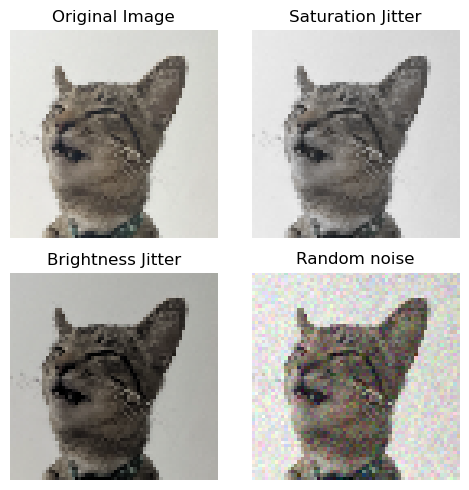

In [101]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
plt.imshow(test)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(test_sat)
plt.title('Saturation Jitter')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(test_brig)
plt.title('Brightness Jitter')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(test_noise)
plt.title('Random noise')
plt.axis('off')

plt.tight_layout()
plt.show()

In [92]:
ideal_size = 5000
augmentations = [   lambda image: cv2.flip(image, 1), #works fine
                    lambda image: add_random_noise(image), #works fine
                    lambda image: brightness_jitter(image), #issue but inconsistently, so it's a problem with the random choice
                    lambda image: saturation_jitter(image)]#works fine
img = augmentations[2](test)
#plt.imshow(img)

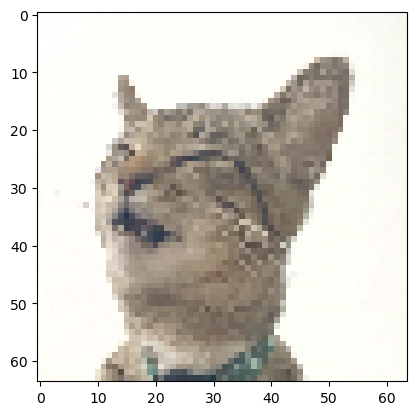

In [93]:
plt.imshow(img)

In [94]:
kodak_images = augment_data(kodak_images, augmentations, ideal_size - len(kodak_images))
not_images = augment_data(not_images, augmentations, ideal_size - len(not_images))
print(len(kodak_images))
print(len(not_images))

5000


# Dataset building
Now that we have the augmentation working, we can stick it all together! 

In [96]:
# Combining the datasets and giving them labels
# Kodak is 1, not kodak is 0
X = np.concatenate((kodak_images, not_images))
y = np.concatenate((np.ones(len(kodak_images)), np.zeros(len(not_images))))

In [97]:
# Reshaping the data
X = np.array(X).reshape(len(X), -1)
y = np.array(y)

10000


In [98]:
# Shuffling the data
X, y = shuffle_data(X, y)

In [99]:
# Creating our train, valid, test sets
X_train, X_val, X_test = split_data(X)
y_train, y_val, y_test = split_data(y)